In [ ]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import glob
import cv2
import gc
import os
from tqdm import tqdm
from os.path import join
import seaborn as sns
import random
import time
import matplotlib.pyplot as plt
from tensorflow import keras 

In [ ]:
# # !mkdir dataset

In [ ]:
##KAGGLE CODE IMPORT CODE
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged
! unzip /content/diabetic-retinopathy-resized-arranged.zip
!rm -rf '/content/diabetic-retinopathy-resized-arranged.zip'

! pip install split-folders

# Arrange Data Into One System  - Rearranging the data in 
!mkdir -p /content/Data/normal/ 
!mkdir -p /content/Data/diabetic_retino
! mv  /content/0/*.jpeg /content/Data/normal/
! mv  /content/1/*.jpeg /content/Data/diabetic_retino
! mv  /content/2/*.jpeg /content/Data/diabetic_retino
! mv  /content/3/*.jpeg /content/Data/diabetic_retino
! mv  /content/4/*.jpeg /content/Data/diabetic_retino
# Removing Folders
!rm -rf '/content/0'
!rm -rf '/content/1'
!rm -rf '/content/2'
!rm -rf '/content/3'
!rm -rf '/content/4'

# Create data for pre-processed data

! rm -rf '/content/processed_data'
! mkdir -p '/content/processed_data/normal'
! mkdir -p /content/processed_data/diabetic_retino

Streaming output truncated to the last 5000 lines.
  inflating: 2/23821_right.jpeg      
  inflating: 2/23852_left.jpeg       
  inflating: 2/23854_left.jpeg       
  inflating: 2/23905_left.jpeg       
  inflating: 2/23905_right.jpeg      
  inflating: 2/23906_left.jpeg       
  inflating: 2/23923_left.jpeg       
  inflating: 2/23923_right.jpeg      
  inflating: 2/23946_left.jpeg       
  inflating: 2/23946_right.jpeg      
  inflating: 2/23961_left.jpeg       
  inflating: 2/23961_right.jpeg      
  inflating: 2/23967_left.jpeg       
  inflating: 2/23967_right.jpeg      
  inflating: 2/239_left.jpeg         
  inflating: 2/239_right.jpeg        
  inflating: 2/24064_left.jpeg       
  inflating: 2/24064_right.jpeg      
  inflating: 2/24074_left.jpeg       
  inflating: 2/24074_right.jpeg      
  inflating: 2/24075_left.jpeg       
  inflating: 2/24076_left.jpeg       
  inflating: 2/24076_right.jpeg      
  inflating: 2/2407_left.jpeg        
  inflating: 2/2407_right.jpeg       

In [ ]:
data_path = '/content/Data'
data_all_imgs = glob.glob(data_path+'/*/*.jpeg')
print("Total number of images ",len(data_all_imgs))
# Set Data parameters 
IMG_SIZE=(512,512)
CLASS_NAMES = ['Normal','Diabetic']

Total number of images  35126


# Image Pre-Processing

/content/Data/diabetic_retino/20967_left.jpeg


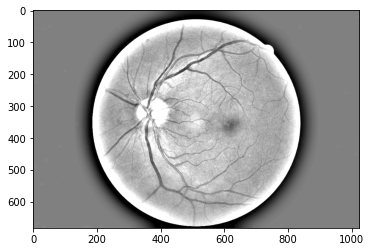

In [ ]:
sigmaX = 30
test_img = data_all_imgs[np.random.randint(0,len(data_all_imgs))]
print(test_img)
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img2=cv2.addWeighted (img,4, cv2.GaussianBlur(img , (0,0) , IMG_SIZE/10) ,-4 ,128)
img=cv2.addWeighted (img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
plt.imshow(img,cmap='gray')
# plt.imshow(img2,cmap='gray')

In [ ]:
def pre_process_img(filename,sigmaX=30):
  img = cv2.imread(filename)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img,IMG_SIZE,interpolation=cv2.INTER_NEAREST)
  img = cv2.addWeighted (img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
  return img

for img_name in tqdm(data_all_imgs, position=0, leave=True):
  process_img= pre_process_img(img_name)  
  save_path = img_name.replace('Data','processed_data')
  # if not os.path.isdir(os.path.split(save_path)[0]):
  #   os.makedirs(os.path.split(save_path)[0])
  cv2.imwrite(str(save_path),process_img)
  time.sleep(0.1)
  



100%|██████████| 35126/35126 [1:46:40<00:00,  5.49it/s]


# Create Data Set 


In [ ]:
import splitfolders
input_data = '/content/Data'
output_data = '/content/output'
splitfolders.ratio(input_data, output=output_data,seed=1337, ratio=(.8, .1, .1), group_prefix=None)

In [ ]:
train_data =glob.glob(output_data+'/train/*/*.jpeg')
print("Training data ",len(train_data))
test_data =glob.glob(output_data+'/test/*/*.jpeg')
print("Test data ",len(test_data))
val_data =glob.glob(output_data+'/val/*/*.jpeg')
print("validation data ",len(val_data))

In [ ]:
img_files = [os.path.basename(name) for name in train_data]
train_label = [name.split('/')[-2] for name in train_data]
train_df = pd.DataFrame({'filename':img_files,'label':train_label,})
train_df.to_csv('training_data.csv')

img_files = [os.path.basename(name) for name in test_data]
test_label = [name.split('/')[-2] for name in test_data]
test_df = pd.DataFrame({'filename':img_files,'label':test_label,})
test_df.to_csv('test_data.csv')

gc.collect()

In [ ]:
df = train_df.groupby(['label'])['filename']
imgs_perId =[]
for id , name in df:
    img_path = join('/content/output/train',join(str(id),name[random.choice(name.index)]))
    imgs_perId.append(img_path)
print(imgs_perId)

The folder represents specific class labels.
0 - No DR
1 - Mild
2 - Moderate
3 - Severe
4 - Proliferative DR

In [ ]:
# Display Multiple images in a matix 
fig=plt.figure(figsize=(8, 8))
columns = 2 
rows = 1
for i in range(0, columns*rows):
  if i>=5:break
  img = plt.imread(imgs_perId[i])
  gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  fig.add_subplot(rows, columns, i+1,xlabel=CLASS_NAMES[i])
  plt.imshow(gray_image,cmap='gray')

fig.tight_layout()

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras


In [ ]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale =1/255,
    rotation_range=90,
    zoom_range=0.2)

In [ ]:
train_path = '/content/output/train'
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMG_SHAPE = (IMAGE_HEIGHT,IMAGE_WIDTH)

training_datagen = image_data_generator.flow_from_directory(
train_path,
target_size=IMG_SHAPE,
class_mode='binary',
color_mode = 'grayscale'
)

validation_path = '/content/output/test'

validation_datagen  = image_data_generator.flow_from_directory(
validation_path,
class_mode='binary',
target_size=IMG_SHAPE,
color_mode = 'grayscale'
)


In [ ]:
training_datagen.color_mode

# MODEL CREATION - 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,MaxPooling2D,Input
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2,InceptionV3
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau 
import datetime

In [ ]:
BATCH_SIZE = 8
EPOCHS=10
# # Load the TensorBoard notebook extension
# !rm -rf /content/logs
# %load_ext tensorboard

In [ ]:
def define_model(n_layers=50,BASE_MODEL='ResNet50V2'):
    if BASE_MODEL =='ResNet50V2':
        # Pre-trained model with MobileNetV2
        base_models = ResNet50V2(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),include_top=False)
        for layers in base_models.layers[:n_layers]:
            layers.trainable=False

        input_tensor = Input(shape=(IMAGE_HEIGHT,IMAGE_WIDTH,1) )
        x = Conv2D(3,(3,3),padding='same',activation='relu')(input_tensor) 
        head_model = base_models(x)
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(256,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.2)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=input_tensor,outputs=prediction_layer)

    if BASE_MODEL =='Custom':
      model = tf.keras.models.Sequential([
                                          #additing the 1st convolution layers
                                          tf.keras.layers.Conv2D(32,(3,3) ,activation='relu',input_shape=(512,512,1),padding="same"),
                                          tf.keras.layers.MaxPool2D(),
                                          tf.keras.layers.BatchNormalization(),
                                          
                                          #addition the 2nd convolution layers
                                          tf.keras.layers.Conv2D(32,(3,3) , activation='relu',padding="same"),
                                          tf.keras.layers.MaxPool2D(),
                                          tf.keras.layers.BatchNormalization(),
                                          
                                          #addition the 3rd convolution layers
                                          tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding="same"),
                                          tf.keras.layers.MaxPool2D(),
                                          tf.keras.layers.BatchNormalization(),
                                          
                                          tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding="same"),
                                          tf.keras.layers.MaxPool2D(),
                                          tf.keras.layers.BatchNormalization(),
                                          
                                          tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding="same"),
                                          tf.keras.layers.MaxPool2D(),
                                          tf.keras.layers.BatchNormalization(),
                                          
                                          tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding="same"),
                                          tf.keras.layers.MaxPool2D(),
                                          tf.keras.layers.BatchNormalization(),
                                        
                                          tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding="same"),
                                          tf.keras.layers.MaxPool2D(),
                                          tf.keras.layers.BatchNormalization(),
                                          
                                          tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding="same"),
                                          tf.keras.layers.MaxPool2D(),
                                          tf.keras.layers.BatchNormalization(),
                                          
                                          # tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding="same"),
                                          # # tf.keras.layers.MaxPool2D(),
                                          # # tf.keras.layers.BatchNormalization(),
                                          
                                          # tf.keras.layers.Conv2D(512,(3,3),activation='relu',padding="same"),
                                          # tf.keras.layers.MaxPool2D(),
                                          # tf.keras.layers.BatchNormalization(),
                                          # tf.keras.layers.Dropout(0.5),
                                          
                                          tf.keras.layers.Flatten(),
                                          tf.keras.layers.Dense(1024,activation='relu'),
                                          tf.keras.layers.Dropout(0.5),
                                          # tf.keras.layers.Dense(1024,activation='relu'),
                                          tf.keras.layers.Dense(2, activation='sigmoid')])
    return model



In [ ]:
# define Model 
model= define_model(BASE_MODEL='Custom')
#Compilation of the model
model.compile(optimizer=RMSprop(lr=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()

In [ ]:
# %tensorboard --logdir logs

In [ ]:
from sklearn.utils import class_weight
classweights = class_weight.compute_class_weight('balanced',
                                                 np.unique(training_datagen.labels),
                                                 training_datagen.labels)
print(classweights)
classweight = {0: classweights[0], 1: classweights[1]}

print('Weight for class 0: {:.2f}'.format(classweights[0]))
print('Weight for class 1: {:.2f}'.format(classweights[1]))

In [ ]:
from keras.callbacks import LearningRateScheduler
# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_path = "ResNet50V2/cp.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,monitor='val_loss', verbose=1,
                            save_best_only=True,mode='min')
# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(
    training_datagen,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_datagen,
    callbacks=[cp_callback,learning_rate_reduction]
    )

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()